# Using Dropout in Regression


In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset

%matplotlib inline
torch.manual_seed(0)

In [2]:
class Data(Dataset):

    # Constructor
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x**2
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

    # Plot the data
    def plot(self):
        plt.figure(figsize=(6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy(), label="True Function", color="orange")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

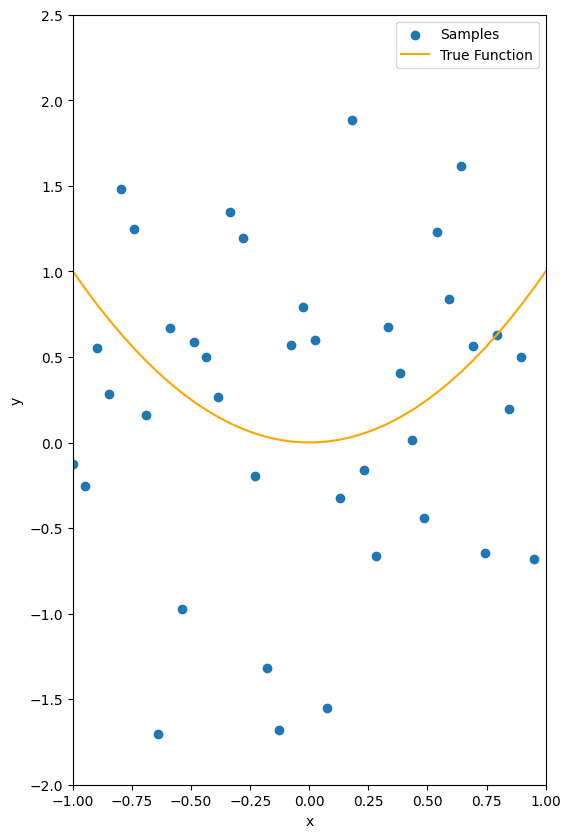

In [3]:
data_set = Data()
data_set.plot()

In [4]:
validation_set = Data(train=False)

In [5]:
class Net(nn.Module):

    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)

    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

In [6]:
model = Net(1, 300, 1)
model_drop = Net(1, 300, 1, p=0.5)

In [7]:
model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

In [8]:
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [9]:
LOSS = {}
LOSS["training data no dropout"] = []
LOSS["validation data no dropout"] = []
LOSS["training data dropout"] = []
LOSS["validation data dropout"] = []

In [10]:
epochs = 500


def train_model(epochs):
    for epoch in range(epochs):
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        # store the loss for  both the training and validation  data for both models
        LOSS["training data no dropout"].append(loss.item())
        LOSS["validation data no dropout"].append(
            criterion(model(validation_set.x), validation_set.y).item()
        )
        LOSS["training data dropout"].append(loss_drop.item())
        model_drop.eval()
        LOSS["validation data dropout"].append(
            criterion(model_drop(validation_set.x), validation_set.y).item()
        )
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()


train_model(epochs)

In [11]:
model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

In [12]:
yhat = model(data_set.x)
yhat_drop = model_drop(data_set.x)

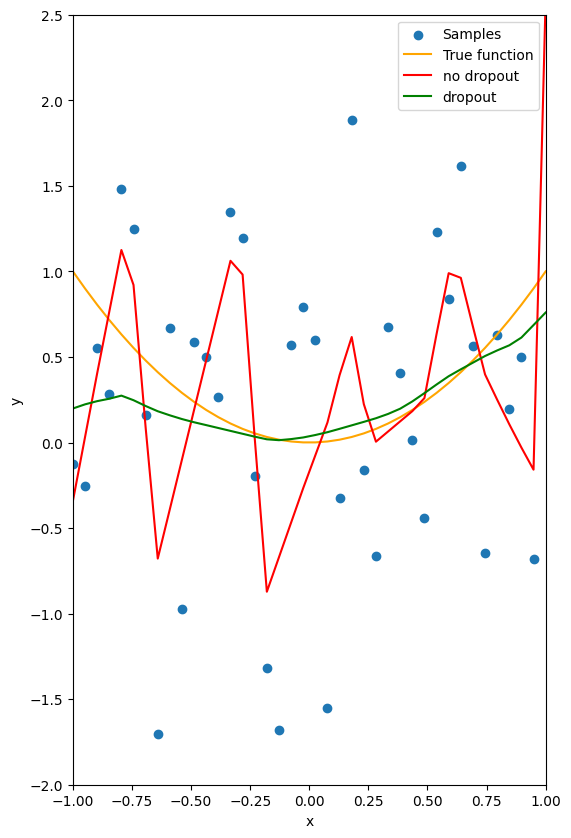

In [13]:
# Plot the predictions for both models

plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color="orange")
plt.plot(data_set.x.numpy(), yhat.detach().numpy(), label="no dropout", c="r")
plt.plot(data_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c="g")

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc="best")
plt.show()

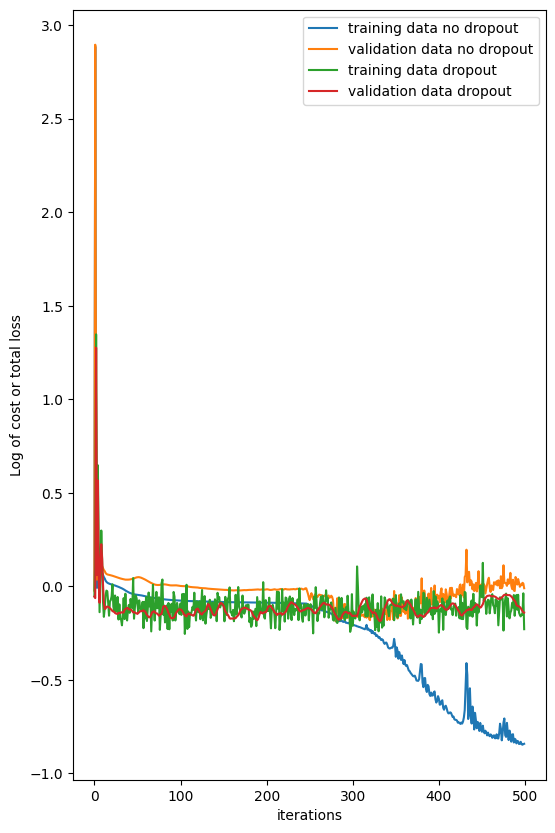

In [14]:
# Plot the loss

plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

The model without dropout performs better on the training data, but it performs worse on the validation data. This suggests overfitting. However, the model using dropout performs better on the validation data, but worse on the training data.
